In [9]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.vector_ar.vecm import coint_johansen
from eda import *
from evaluation import *
from pca_utils import *
from model_fitting import *
from diagnostics import *
from core_filter import *
import preprocessing
import importlib
importlib.reload(preprocessing)
from preprocessing import *
plt.rcParams['figure.figsize'] = (6, 3)
np.set_printoptions(precision=4, suppress=True, linewidth=120)

## General Preprocessing & EDA

#### Obtain data:
1. Federal Funds Effective Rate (DFF): unit in percentage (used as control factor instead of background variable in FAVAR framework)
2. Core CPI (CPILFESL): unit in index values
3. Unemployment Rate (UNRATE): unit in percentage
4. Real GDP (GDP): unit in billions of dollars

In [2]:
raw_data_path = 'data/raw'
daily_factors = ['DFF']
monthly_factors = ['CPILFESL','UNRATE']
quarterly_factors = ['GDP']
df = read_data(data_path=raw_data_path, daily_factors=daily_factors, monthly_factors=monthly_factors, quarterly_factors=quarterly_factors)
display(df)

,DFF,CPILFESL,UNRATE,GDP
observation_date,,,,
1985-04-01,8.475111,107.633333,7.233333,4294.887
1985-07-01,7.924396,108.766667,7.300000,4386.773
1985-10-01,7.900978,109.733333,7.200000,4444.094
1986-01-01,8.104457,111.000000,7.033333,4507.894
1986-04-01,7.826889,112.200000,7.033333,4545.340
...,...,...,...,...
2023-10-01,5.259239,309.740333,3.666667,28296.967
2024-01-01,5.330000,312.345333,3.800000,28624.069
2024-04-01,5.330000,315.568667,3.833333,29016.714


In [3]:
# set aside a fully untouched test set before eda
split_date = '2021-01-01'
eda_train_df = df[df.index < split_date]

#### EDA:
1. stationary 
 - Macro level data is highly trending, which will lead to nonstationary initial setups if unresolved. Using level data increases the risk of explosive transition matrix in the state model, which may lead to unbounded gradient variances and explosive gradients.
 - Differencing removes memory and instead models delta_Y, will need post-processing to recover level-wise prediction.
2. structural breaks
 - Structural breaks are visible for policy rate and unemployment rate using simple stats check, but no sharp breaks are present. This may suggest the validity of a long training window size.
3. outliers
 - Outliers for policy rate are more indications of structural breaks. There are indeed outliers around 2008 and Covid for unemployment rate.
4. data distribution
 - Variables are mostly right-skewed except for CPI.


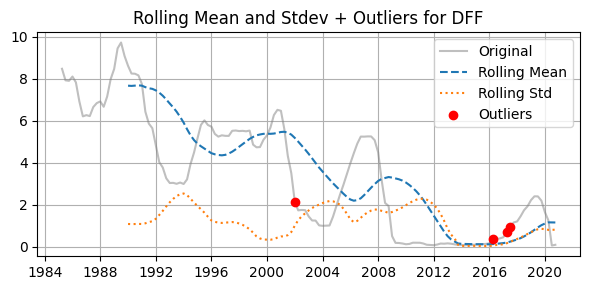

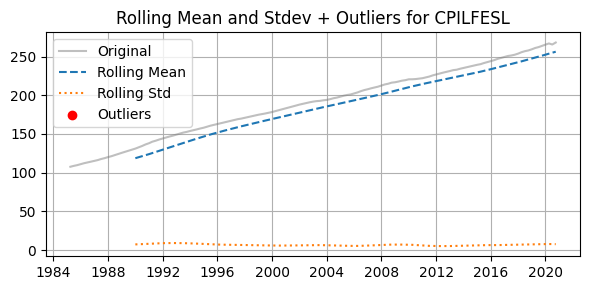

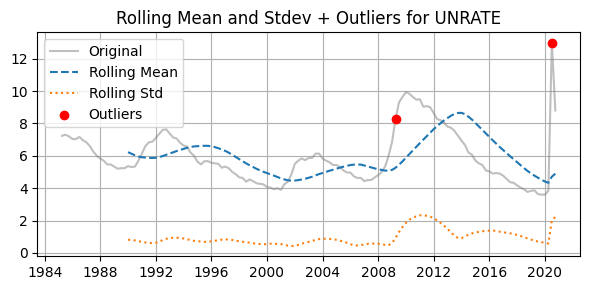

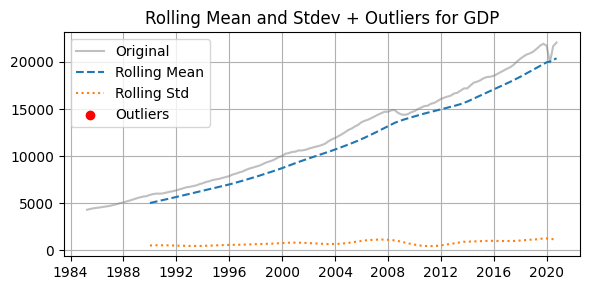

In [4]:
eda(eda_train_df)

In [5]:
adf_train = adf_test_all_features(eda_train_df)
display(adf_train)

,Feature,ADF Statistic,p-value,Stationary,Critical Values
0,DFF,-2.016504,0.279384,No,"{'1%': -3.4776006742422374, '5%': -2.882265832..."
1,CPILFESL,-0.993820,0.755512,No,"{'1%': -3.481281802271349, '5%': -2.8838678916..."
2,UNRATE,-2.588149,0.095472,No,"{'1%': -3.4779446621720114, '5%': -2.882415612..."
3,GDP,1.980021,0.998646,No,"{'1%': -3.4779446621720114, '5%': -2.882415612..."


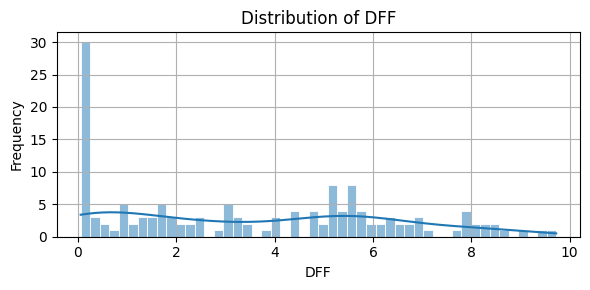

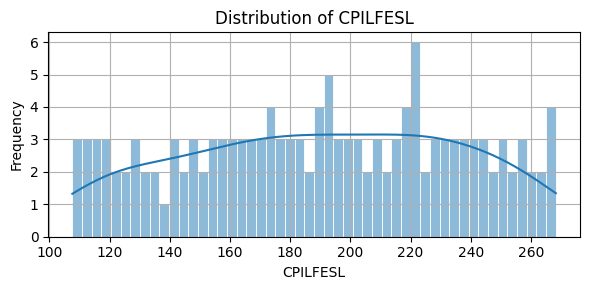

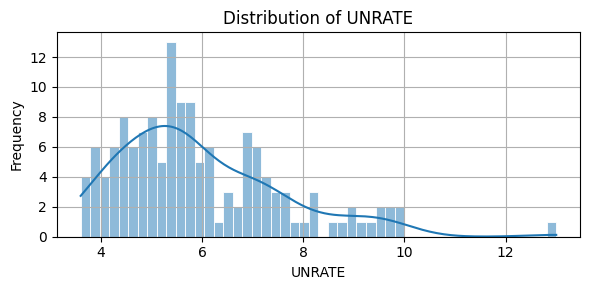

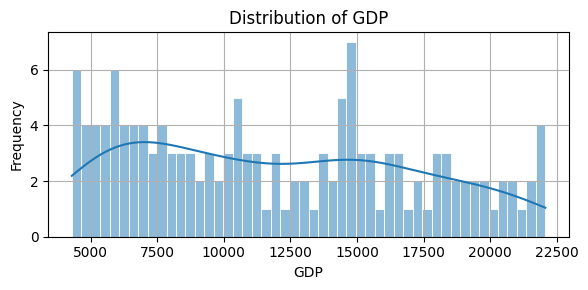

In [6]:
distribution(eda_train_df)

#### Preprocessing:
1. Differencing
 - Log differencing is applied to CPI and GDP.
 - DFF and UNRATE are relatively stationary and kept as level data.
 - If differencing is not ideal, there are alternatives like adding constraints on eignevalues of transition matrix A or applying regularizations to avoid explosive variance.
2. Standardization
 - Standardization to z-score is applied per rolling window to all variables. 
 - PCA and backpropagation are both sensitive to scale.
3. Outlier cap
 - Redundant. The loss function will include the prediction errors triggered by outliers and the information will be passed on to model parameters during back propagation.

Both differencing and standardization can be post-processed to original scale and level. That is, although Kalman filtering and the subsequent loss function are built on the standardized rate scale, we can recover train and test predictions back to original scale and level (although may suffer from cumulative errors). Whether recovering is needed depends on purpose.

After first-order log difference, CPI is still slightly non-stationary. Since its rolling mean and stdev is relatively stable locally, I believe it is stationary within a rolling window method. The non-stationary is likely due to regime shift, so second-order log difference is not necessary.

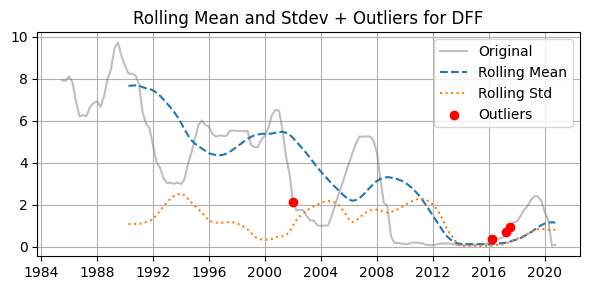

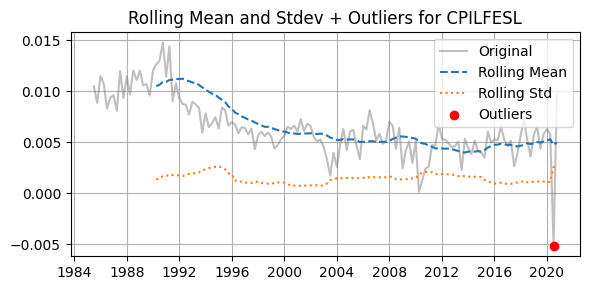

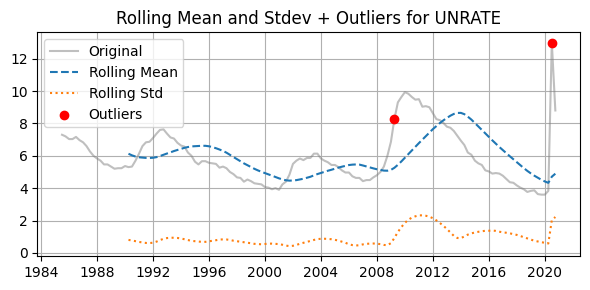

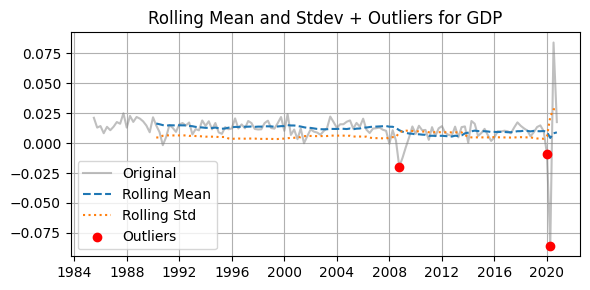

,Feature,ADF Statistic,p-value,Stationary,Critical Values
0,DFF,-2.188185,2.105614e-01,No,"{'1%': -3.4779446621720114, '5%': -2.882415612..."
1,CPILFESL,-2.054659,2.631325e-01,No,"{'1%': -3.4782936965183815, '5%': -2.882567574..."
2,UNRATE,-2.557786,1.020396e-01,No,"{'1%': -3.4782936965183815, '5%': -2.882567574..."
3,GDP,-13.055731,2.096855e-24,Yes,"{'1%': -3.4776006742422374, '5%': -2.882265832..."


In [7]:
log_diff_cols = ['CPILFESL', 'GDP']
diff_cols = []
stationary_df = make_stationary(df, log_diff_cols, diff_cols)

# verify staionary
eda_train_df_stationary = stationary_df[stationary_df.index < split_date]
eda(eda_train_df_stationary)
display(adf_test_all_features(eda_train_df_stationary))

## Experiment on first window's data

### Initialization

Preprocessing by window:

standardization & eda

outlier cap by mad per window is turned off

2025-04-27 14:41:52,119 - INFO - Standardization complete.
2025-04-27 14:41:52,123 - INFO - Window initialized with size 48. Features: ['DFF', 'CPILFESL', 'UNRATE', 'GDP']


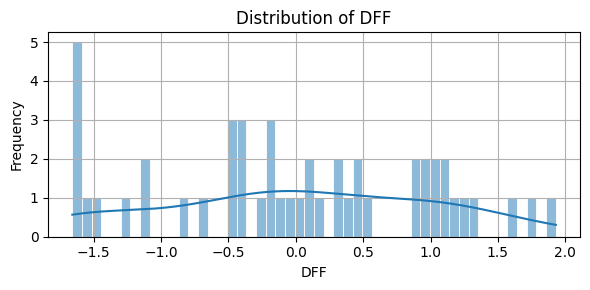

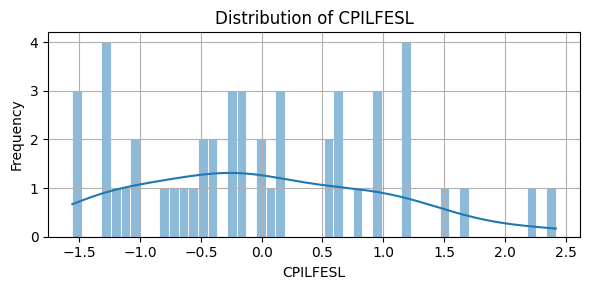

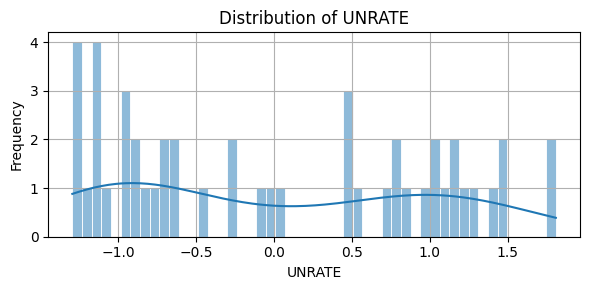

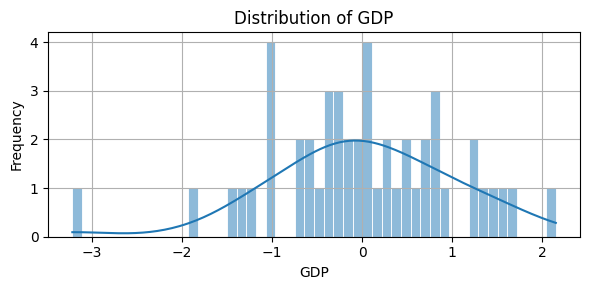

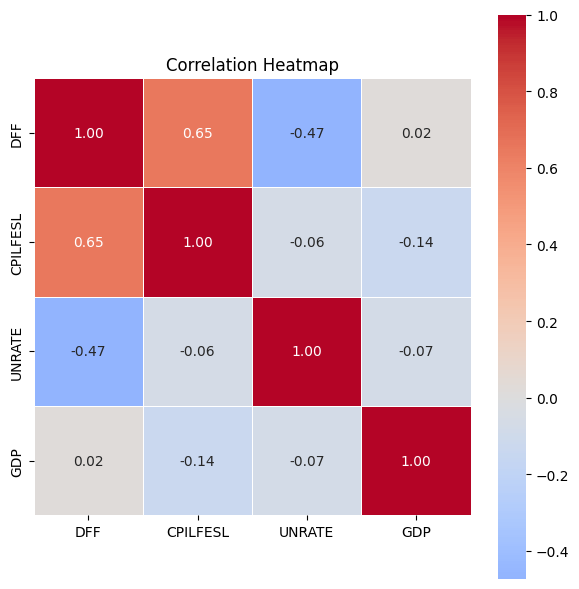

In [11]:
clipping_factors = []
experiment_df , experiment_scaler = initialize_by_window(stationary_df, clipping_factors=clipping_factors, plot=True)

#### PCA
 - Scree plot to choose latent dimension d
 - Time series plot of top d principal components

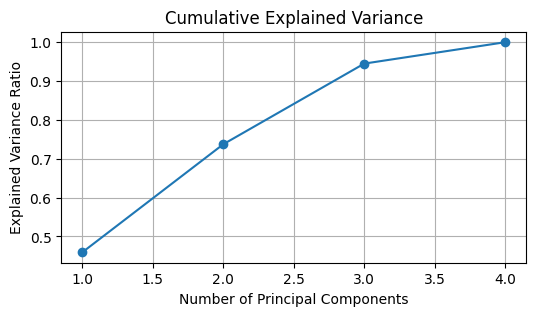

,DFF,CPILFESL,UNRATE,GDP
0,0.691549,0.577394,-0.432033,-0.041517
1,0.051390,-0.375348,-0.494547,0.782238
2,0.082098,0.434212,0.652570,0.615526
3,0.715807,-0.580680,0.378052,-0.086646


In [12]:
display(scree_plot(experiment_df))

There is no elbow present in the scree plot, meaning the variance is evenly spread across features. 

I choose number of components $k$ to be 2 because:
 - The first two components explain ~75% of the variance, which is relatively good.
 - The residuals from projecting onto the PCs lie in the orthogonal complement, meaning the sample covariance matrix $R$ of the residuals has rank at most $n-k$. We need the rank of $R$ not too small to prevent filter collapsing.

Even with differencing on observable data, some of our principal components are still nonstationary.

2025-04-27 14:42:24,513 - INFO - PCA complete. Explained variance ratio: [0.4593 0.2781]


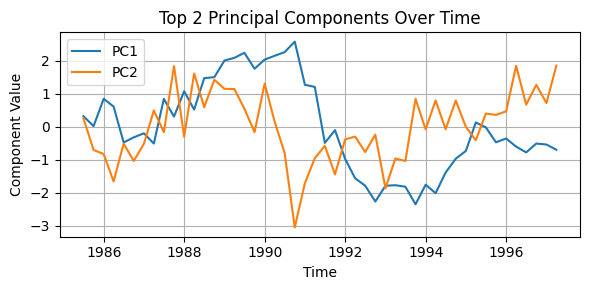

,Feature,ADF Statistic,p-value,Stationary,Critical Values
0,PC1,-1.630084,0.467447,No,"{'1%': -3.584828853223594, '5%': -2.9282991495..."
1,PC2,-1.833608,0.363908,No,"{'1%': -3.5812576580093696, '5%': -2.926784912..."


In [13]:
experiment_latent_df = pca(experiment_df, plot=True)
display(adf_test_all_features(experiment_latent_df))

From the heatmap of original level-based variables, there is strong correlation coming from shared trends as it greatly shrinks with differencing. 

For curiosity, cointegration test is performed on standardized level data and it shows no significant cointegrating relationship.

If we apply above procedure for PCA to level-based data, we can see the first two PCs dominate the explained variance. 

Especially for the first PC, it is simply the upward trend as all variables are trending upward. This shows that shared trends inflate the first principal component. 

And for the second PC, it is dominated by unemployment rate.

Given this observation, I will proceed with the PCs generated after differencing data as they better capture the structural relationship between variables.

2025-04-27 14:42:45,332 - INFO - Standardization complete.
2025-04-27 14:42:45,335 - INFO - Window initialized with size 48. Features: ['DFF', 'CPILFESL', 'UNRATE', 'GDP']
2025-04-27 14:42:45,379 - INFO - PCA complete. Explained variance ratio: [0.6294 0.3431]


[47.3015 22.6775  7.8294  1.0318]
[[44.4929 47.8545 54.6815]
 [27.0669 29.7961 35.4628]
 [13.4294 15.4943 19.9349]
 [ 2.7055  3.8415  6.6349]]


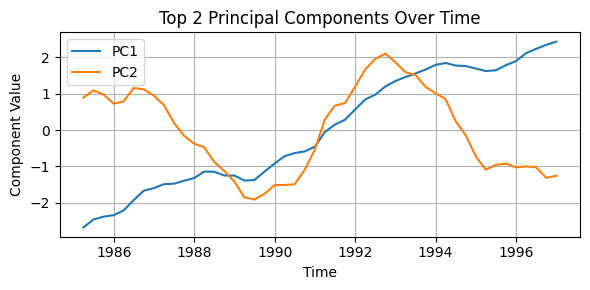

2025-04-27 14:42:45,689 - INFO - PCA complete. Explained variance ratio: [0.6294 0.3431]


,Feature,ADF Statistic,p-value,Stationary,Critical Values
0,PC1,-0.468558,0.898008,No,"{'1%': -3.5812576580093696, '5%': -2.926784912..."
1,PC2,-4.928432,0.000031,Yes,"{'1%': -3.596635636000432, '5%': -2.9332973318..."


In [15]:
experiment_level_df , _ = initialize_by_window(df, clipping_factors=clipping_factors, plot=False)
# check cointegration for insight
result = coint_johansen(experiment_level_df, det_order=0, k_ar_diff=1)
print(result.lr1)  # Trace statistics
print(result.cvt)  # Critical values
pca(experiment_level_df, plot=True)
display(adf_test_all_features(pca(experiment_level_df, n_components=2)))

#### VAR

Now we fit VAR(1) to the state space model:
$$
X_t = A X_{t-1} + G \epsilon_t.
$$
where A is the transition matrix, and G is lower triangualr matrix from the Cholesky decomposition of the covariance matrix $Q$ of the residuals $\epsilon_t$.

 - As said before, principal components from relatively stationary time series can still contain autocorrelation.  We inspect eigenvalues of A (should lie inside the unit circle for A to be stable). Instead of applying differencing on PCs again before fitting VAR, I choose to rescale A to shrink its influence to lie inside the unit circle.
 - In cases where $Q$ (Cov($\epsilon_t$)) is not P.D., I apply ridge regularization (adding a small positive value to the diagonal) to ensure it becomes positive definite. Maybe a better alternative is applying SVD approximation instead.

In [16]:
A, G, epsilon = fit_state_space_model(experiment_latent_df)

2025-04-27 14:42:53,595 - INFO - Fitting VAR(1) model to latent state series with shape (48, 2).
2025-04-27 14:42:53,606 - INFO - VAR coefficients extracted. Projecting A to ensure stability.
2025-04-27 14:42:53,608 - INFO - Matrix A is already stable (spectral radius < 1).
2025-04-27 14:42:53,609 - INFO - Covariance matrix Q is positive definite. Cholesky decomposition successful.


In [21]:
epsilon.shape

(47, 2)

In [22]:
eta.shape

(48, 4)

### OLS

Now we fit OLS to the observation model:
$$
Y_t = B X_{t} + H \eta_t.
$$
where B is the observation matrix, and H is lower triangualr matrix from the Cholesky decomposition of the covariance matrix $R$ of the residuals $\eta_t$.

 - Since we only fit OLS to set up initial estimates for B and H,  we can directly use QR decomposition to solve for B.

 - As we have noted above, $R$ is likely rank-deficient as $\text{rank}(R) \leq n-k$. Thus, we need to apply ridge regularization to R. Current hyperparameter is 1e-2.

In [17]:
B, H, eta = fit_observation_model(experiment_df, experiment_latent_df)

2025-04-27 14:43:00,577 - INFO - Fitting OLS observation model with Y shape (48, 4), X shape (48, 2).
2025-04-27 14:43:00,581 - WARNING - Covariance matrix R is not positive definite. Applying ridge regularization.
2025-04-27 14:43:00,584 - INFO - Singular values of residuals: [6.3129 3.2516 0.     0.    ]
2025-04-27 14:43:00,585 - INFO - Applying ridge regularization to covariance matrix with ε = 0.01.
2025-04-27 14:43:00,587 - INFO - Cholesky decomposition after regularization successful.


#### Initialization Sanity Check:

1. Check $\text{Cov}(\epsilon_t^{(i)}, \eta_t^{(j)}), \quad \forall i \in \{1, \dots, k\}, \quad \forall j \in \{1, \dots, n\}$. 
 - Ideally, under the Kalman filter assumption, this matrix should be approximately zero.
 - If violated, log a warning and set the check flag to False.
 - If violations are persistent, consider using a Kalman filter with cross-noise terms.

2. Check $\text{Cov}(X_t^{(i)}, \eta_t^{(j)}), \quad \forall i \in \{1, \dots, k\}, \quad \forall j \in \{1, \dots, n\}$. 
 - The matrix should be zero as well as $\eta_t$ is the innovation in the update phase, which should be independent of current latent states.
 - Violation of this assumption distorts the Kalman gain calculation (over- or under- weighted) and leads to biased filter.
 - If violated, log a warning and set the flag to False for review.

3. Check if process noise $\epsilon_t$ is white noise.
 - If violated, log a warning and set the flag to False.
 - Possible fix: re-run the VAR with a higher lag order。

4. Check if observation noise $\eta_t$ is white noise.
 - If residuals from observation model shows autocorrelation, it is likely because 
   - the observation model lacks lagged terms of latent states 
   - ommitted variable 
   - dependent variable is correlated in nature (unlikely, as have been resolved in preprocessing steps)
 - If violated, log a warning and flag the issue.
 - Possible fix: include lagged $X_t$ terms in the observation model or expand the latent state definition (concatenate other observable factor or current $\eta$).

5. Check if $R = HH^T$ after ridge is well-conditioned.
 - R being small would likely leads to singular innovation covariance $S$ and a failed inverse operation for computing Kalman gain.
 - A small $R$ drives aggressive variance compression, leading to state covariance collapsing in Kalman filter.
- This check is diagnostic only, no flags are raised.

6. Check if $Q = GG^T$ after ridge is well-conditioned.
 - Well-conditioned Q adds uncertainty to posterior covariance.
 - This check is diagnostic only, no flags are raised.

7. Check residual plot for signs of heteroscedasticity.
- Heteroscedasticity in the innovations can affect Kalman gain stability and signal latent nonstationarity or model mismatch.
 - This check is diagnostic only, no flags are raised.

8. Check if $\epsilon_t$ and $\eta_t$ have zero mean.
 - Redundant: np.cov() used in covariance calculations automatically removes the sample mean.

2025-04-27 14:43:09,824 - INFO - === Kalman Initialization Sanity Checks ===
2025-04-27 14:43:09,827 - INFO - Step 1: Checking cross-covariance between epsilon and eta...
2025-04-27 14:43:09,829 - INFO - Empirical Covariance between epsilon and eta:
[[-0.0605  0.0686 -0.0081  0.0318]
 [ 0.0237  0.0569  0.105   0.0921]]
2025-04-27 14:43:09,831 - WARNING - Max absolute cross-covariance (0.10503) exceeds tolerance (0.1) between epsilon and eta.
2025-04-27 14:43:09,832 - INFO - Step 2: Checking cross-covariance between X and eta...
2025-04-27 14:43:09,834 - INFO - Empirical Covariance between X and eta:
[[ 0.  0. -0.  0.]
 [-0.  0.  0. -0.]]
2025-04-27 14:43:09,835 - INFO - All cross-covariance entries between X and eta are within the tolerance 0.1.
2025-04-27 14:43:09,837 - INFO - Step 3: Checking whiteness of epsilon (state residuals)...
2025-04-27 14:43:09,842 - INFO - epsilon[0] Ljung-Box p=0.7935 — no autocorrelation
2025-04-27 14:43:09,844 - WARNING - epsilon[1] Ljung-Box p=0.0034 — 

Plotting residual diagnostics for epsilon:


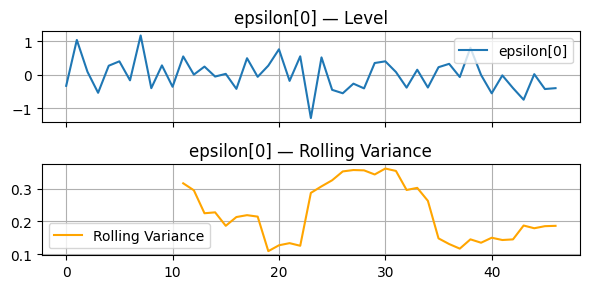

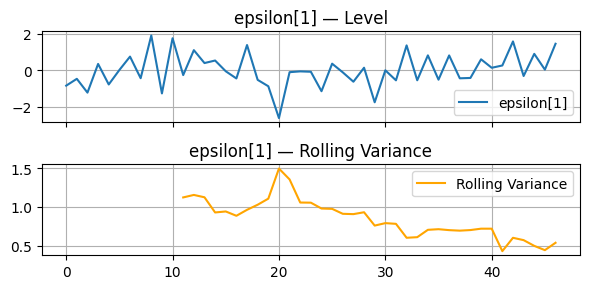

Plotting residual diagnostics for eta:


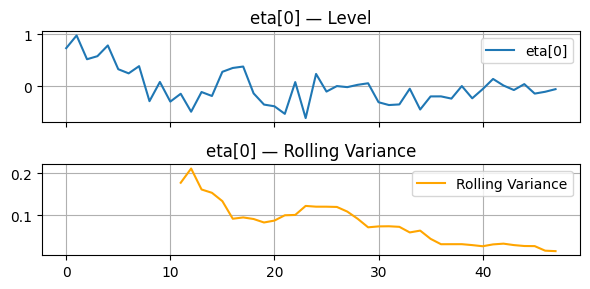

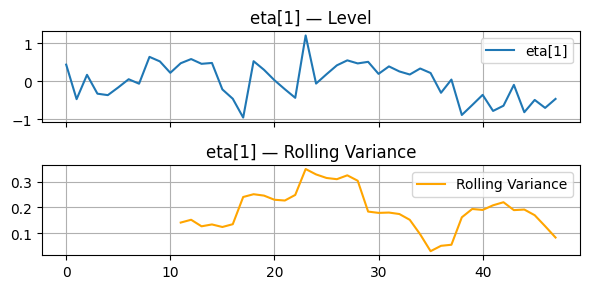

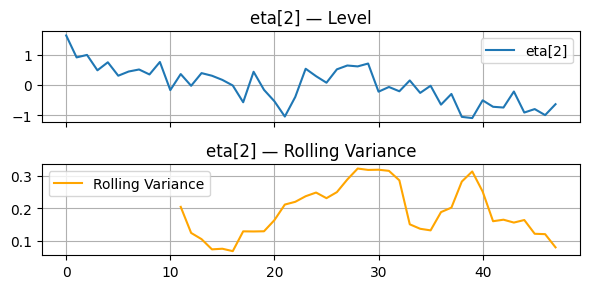

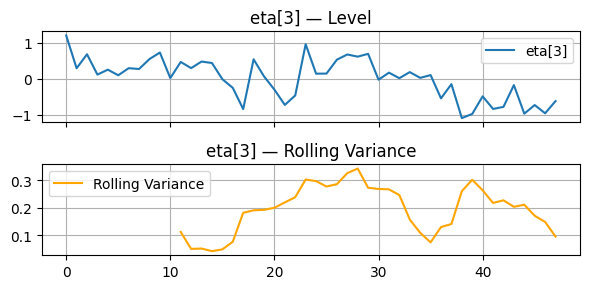

2025-04-27 14:43:12,119 - INFO - Step 7 skipped: Mean-centering is implicitly handled in covariance computation.
2025-04-27 14:43:12,121 - INFO - Sanity checks completed.
2025-04-27 14:43:12,121 - INFO - Summary of checks:
{'cross_eps_eta': False, 'cross_X_eta': True, 'white_eps': False, 'white_eta': False}


In [18]:
summary = run_kalman_initialization_checks(
    epsilon=epsilon,
    eta=eta,
    X=experiment_latent_df.values,
    G=G,
    H=H,
)

#### Diagnostics

In the experiment run, we identify following issues:
- Process noise $\epsilon$ and observation noise $\eta$ are all autocorrelated.
    - Fixes are not applied in experiment run - pending decision choice.
- We can spot from residual plots that 
  -  $\epsilon$ and $\eta$ are heteroscedastic and $\eta$ has rank 2.
- The condition number of Q is 2.17, so it is well-conditioned.
 - The condition number of R is 9.26 after ridge, which is acceptable.

### Kalman filter

Now we implement the Kalman Filter for the linear Gaussian state-space model.

$$
X_t = A X_{t-1} + G \varepsilon_t, \quad \varepsilon_t \sim \mathcal{N}(0, I)
$$

$$
Y_t = B X_t + H \eta_t, \quad \eta_t \sim \mathcal{N}(0, I)
$$

#### Initialization

- The initial state \( X_0 \) can be:
  - A **zero vector**.
  - The **first value from a PCA-estimated latent trajectory**.
- The initial covariance \( P_0 \) is a scaled identity matrix:
  $$
  P_0 = \text{certainty factor} \cdot I
  $$
  A higher certainty factor reflects greater initial uncertainty.


---

At each time step $ t = 0, \dots, T-1 $, the filter performs:

#### Prediction Step
- Predicted state:
  $$
  \hat{X}_{t|t-1} = A X_{t-1}
  $$
- Predicted covariance:
  $$
  P_{t|t-1} = A P_{t-1} A^\top + Q
  $$

#### Update Step
- Predicted observation:
  $$
  \hat{Y}_t = B \hat{X}_{t|t-1}
  $$
- Innovation (residual):
  $$
  \nu_t = Y_t - \hat{Y}_t
  $$
- Innovation covariance:
  $$
  S_t = B P_{t|t-1} B^\top + R
  $$
- Kalman gain:
  $$
  K_t = P_{t|t-1} B^\top S_t^{-1}
  $$
- Updated state:
  $$
  X_t = \hat{X}_{t|t-1} + K_t \nu_t

In [19]:
X_filt, P_all, innovations, S_list = run_kalman_filter(Y=experiment_df.values, A=A, B=B, G=G, H=H)

2025-04-27 14:44:26,956 - INFO - Starting Kalman Filter execution...
2025-04-27 14:44:26,958 - INFO - State dimension k=2, certainty factor for P0=1
2025-04-27 14:44:26,960 - INFO - Initializing latent state as zero vector.
2025-04-27 14:44:26,962 - INFO - Running Kalman filter for 48 time steps.
2025-04-27 14:44:26,964 - INFO - Kalman gain K[0]:
[[ 0.6855  0.5725 -0.4282 -0.0413]
 [ 0.0508 -0.3722 -0.4902  0.7754]]
2025-04-27 14:44:26,966 - INFO - Kalman gain K[1]:
[[ 0.6598  0.5546 -0.4082 -0.0465]
 [ 0.0447 -0.3755 -0.4843  0.7723]]
2025-04-27 14:44:26,968 - INFO - Kalman gain K[2]:
[[ 0.6598  0.5545 -0.4081 -0.0465]
 [ 0.0447 -0.3755 -0.4843  0.7723]]
2025-04-27 14:44:26,971 - INFO - Kalman gain K[3]:
[[ 0.6598  0.5545 -0.4081 -0.0465]
 [ 0.0447 -0.3755 -0.4843  0.7723]]
2025-04-27 14:44:26,973 - INFO - Kalman gain K[4]:
[[ 0.6598  0.5545 -0.4081 -0.0465]
 [ 0.0447 -0.3755 -0.4843  0.7723]]
2025-04-27 14:44:26,988 - INFO - Kalman filter run completed.
2025-04-27 14:44:26,989 - INFO

We can see instant convergence of kalman gain. This is likely due to our observation covariance $R$ being rank-deficient as our process covariance $Q$ and initial uncertainty matrix are normal.

I believe the root cause is right now we do not have enough observable macro series. As we only look at four-dimensional observable, rank-deficiency plays a major part in calculation of kalman gain and prior covariance (making them stablizie rapidly).

#### Post Hoc Evaluation

1. State estimate consistency
    - The filtered latent state trajectory $X_t$ is plotted against the PCA-initialized latent estimate. Confidence intervals are constructed from the diagonal of the posterior covariance matrix $P_t$, typically visualized as 95% bands. 

2. State magnitude and uncertainty over time
   - The norm $\|X_t\|$ is plotted to track the magnitude of the filtered state.
   - The trace of the posterior covariance matrix $\operatorname{tr}(P_t)$ is used to monitor how the uncertainty in state estimation evolves. 

3. Cross-covariance between state and innovation
   - Same as in initialization sanity check, the empirical cross-covariance between the filtered state $X_t$ and the innovation $\nu_t = Y_t - B X_t$ is computed. 

4. Innovation whiteness
   - Same as in initialization sanity check, each dimension of the innovation sequence $\nu_t$ is tested for autocorrelation. 

5. Innovation heteroscedasticity
   - Same as in initialization sanity check, the level and rolling variance of each innovation component are plotted over time to detect time-varying volatility. 

6. Innovation mean stability
   - Innovations should be approximately zero-mean under the Gaussian error assumption. 
   - Persistent nonzero means may indicate bias in the observation equation or incorrect model calibration.

7. Observation reconstruction accuracy
   - Using the filtered states, observations are reconstructed as $\hat{Y}_t = B X_t$. 
   - The predicted series is compared to the observed data using RMSE and $R^2$.

8. One-step-ahead prediction accuracy
   - The Kalman filter’s forecast $\hat{Y}_{t+1|t} = B A X_t$ is compared with the actual observation $Y_{t+1}$. 
   - This out-of-sample evaluation reflects the filter’s predictive power and generalization performance.

9. Log-likelihood computation
   - The total log-likelihood is computed based on the innovations and their associated covariances:
   $$
   \log L(\theta \mid Y_{1:T}) = \sum_{t=1}^T \log \mathcal{N}(\nu_t \mid 0, S_t)
   $$
   where $S_t$ is the innovation covariance. 
   - The resulting score summarizes overall model fit and can be used for model selection or comparison.

2025-04-27 14:44:29,869 - INFO - === Kalman Pipeline Evaluation ===
2025-04-27 14:44:29,871 - INFO - Step 1: Evaluating state estimate consistency...
2025-04-27 14:44:29,872 - INFO - Plotting state consistency...


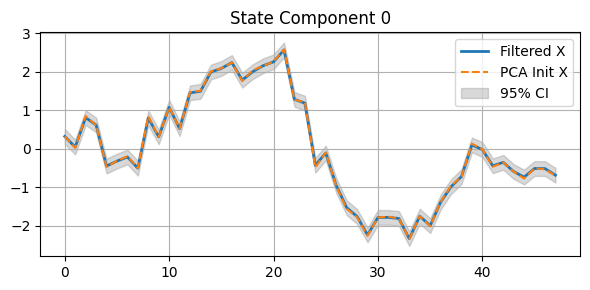

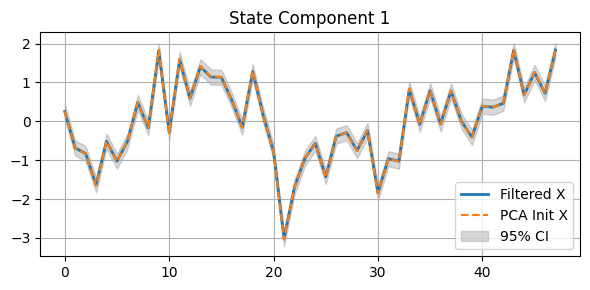

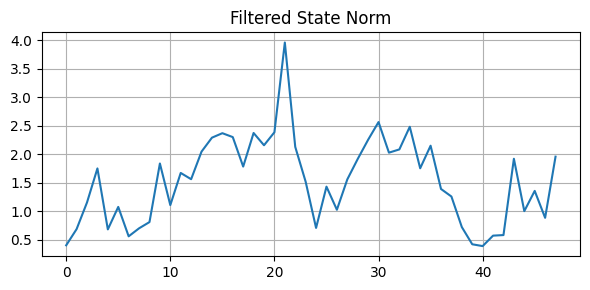

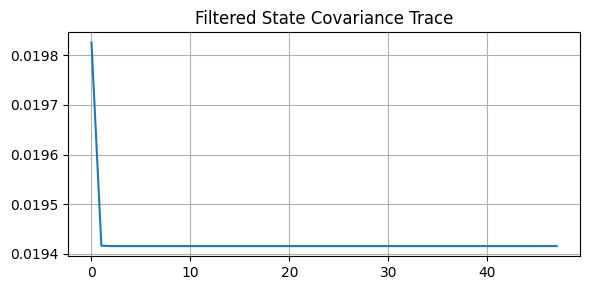

2025-04-27 14:44:30,660 - INFO - Step 2: Performing residual diagnostics...
2025-04-27 14:44:30,661 - INFO - Empirical Covariance between X_filt and Innovation:
[[ 0.1524  0.1901 -0.0187 -0.1397]
 [-0.0681 -0.4076 -0.3448  0.6583]]
2025-04-27 14:44:30,662 - WARNING - Max absolute cross-covariance (0.65832) exceeds tolerance (0.1) between X_filt and Innovation.
2025-04-27 14:44:30,664 - WARNING - Innovation[0] Ljung-Box p=0.0000 — autocorrelation exists
2025-04-27 14:44:30,666 - WARNING - Innovation[1] Ljung-Box p=0.0086 — autocorrelation exists
2025-04-27 14:44:30,668 - WARNING - Innovation[2] Ljung-Box p=0.0000 — autocorrelation exists
2025-04-27 14:44:30,669 - INFO - Innovation[3] Ljung-Box p=0.2031 — no autocorrelation


Plotting residual diagnostics for Innovation:


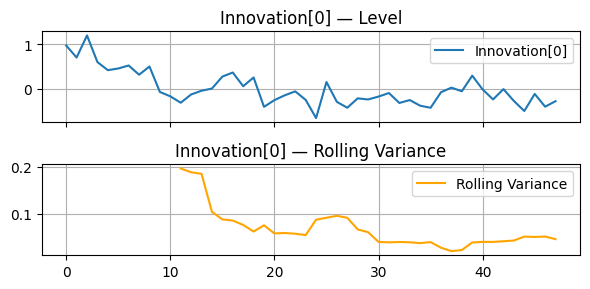

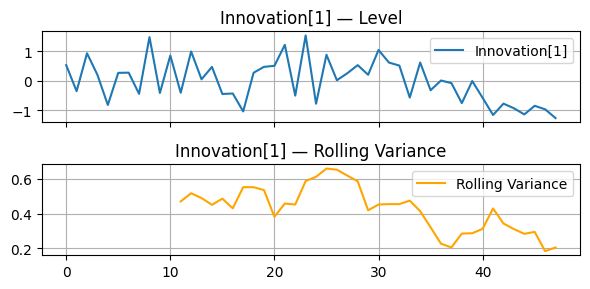

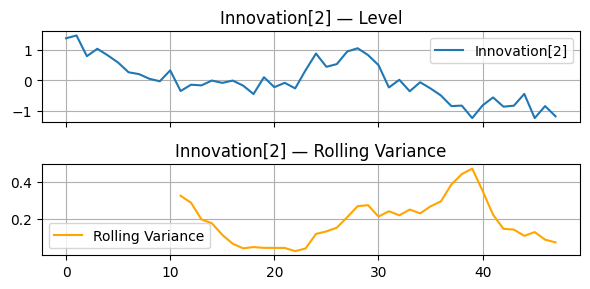

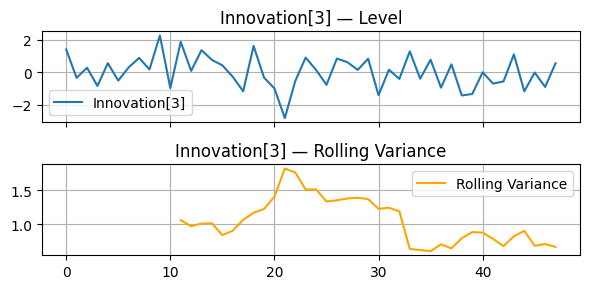

2025-04-27 14:44:31,996 - WARNING - Innovation mean not zero within tolerance 0.001: [-0.0005 -0.0089 -0.009   0.0159]
2025-04-27 14:44:31,998 - INFO - Step 3: Evaluating observation reconstruction accuracy...
2025-04-27 14:44:31,998 - INFO - Evaluating filtered accuracy...
2025-04-27 14:44:32,003 - INFO - Y[0] (filtered) — RMSE: 0.3397, R^2: 0.8846


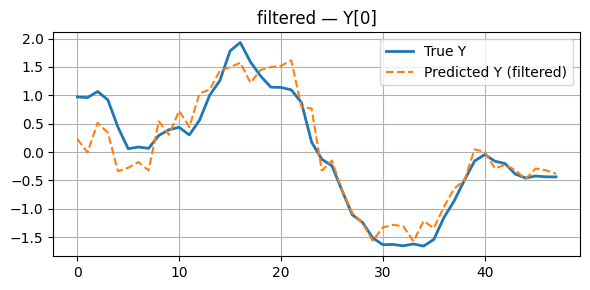

2025-04-27 14:44:32,249 - INFO - Y[1] (filtered) — RMSE: 0.4837, R^2: 0.7661


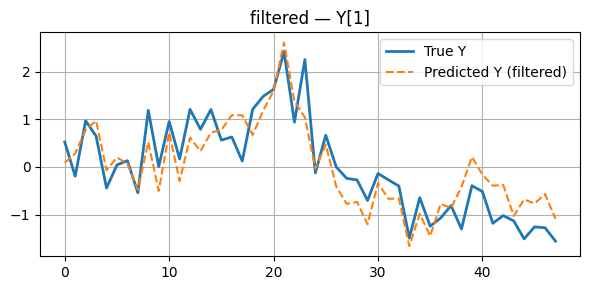

2025-04-27 14:44:32,439 - INFO - Y[2] (filtered) — RMSE: 0.6191, R^2: 0.6167


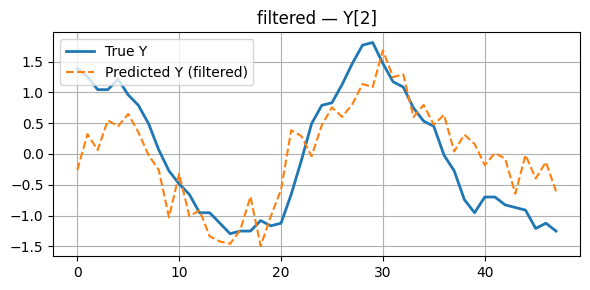

2025-04-27 14:44:32,785 - INFO - Y[3] (filtered) — RMSE: 0.5643, R^2: 0.6816


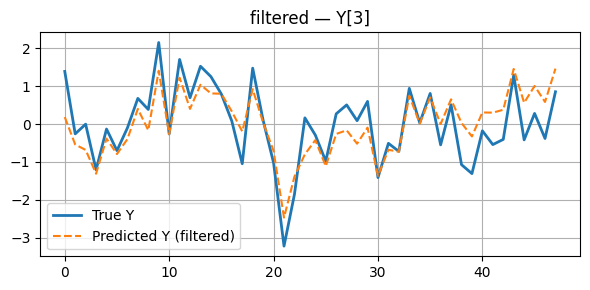

2025-04-27 14:44:33,009 - INFO - Step 4: Evaluating one-step-ahead prediction...
2025-04-27 14:44:33,010 - INFO - Evaluating t+1 prediction accuracy...
2025-04-27 14:44:33,012 - INFO - Y[0] (t+1 prediction) — RMSE: 0.3593, R^2: 0.8710


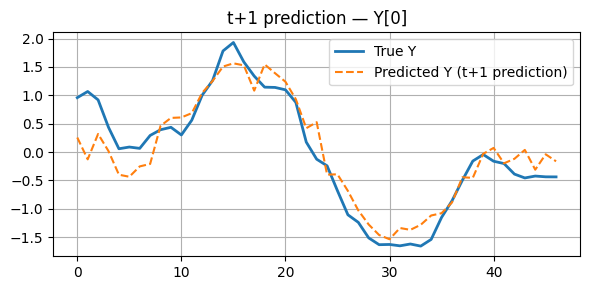

2025-04-27 14:44:33,234 - INFO - Y[1] (t+1 prediction) — RMSE: 0.7293, R^2: 0.4761


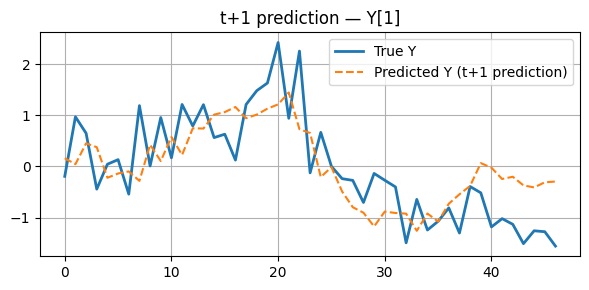

2025-04-27 14:44:33,508 - INFO - Y[2] (t+1 prediction) — RMSE: 0.6472, R^2: 0.5725


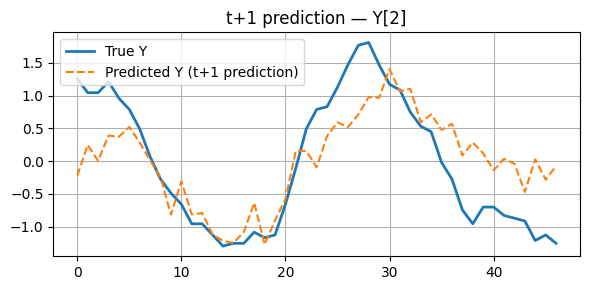

2025-04-27 14:44:33,736 - INFO - Y[3] (t+1 prediction) — RMSE: 0.9770, R^2: 0.0254


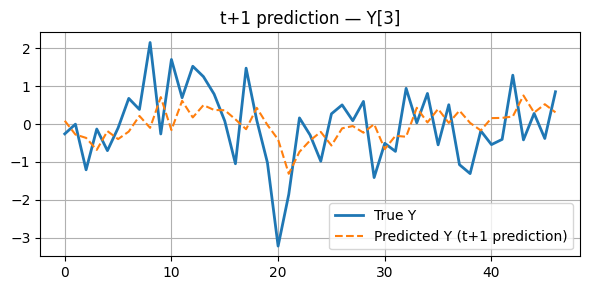

2025-04-27 14:44:33,973 - INFO - Step 5: Computing log-likelihood...
2025-04-27 14:44:33,974 - INFO - Computing total log-likelihood from Kalman innovations...
2025-04-27 14:44:33,977 - INFO - Final computed log-likelihood: -188.4193


In [20]:
logL = evaluate_kalman_pipeline(Y=experiment_df.values, X_filt=X_filt, X_pca=experiment_latent_df, B=B, A=A, innovations=innovations, S_list=S_list, P_all=P_all)

#### Evaluation

In the experiment run, we identify following issues:
- Filtered state $X_t$ and innovation $\eta_t$ are not orthogonal, with empirical cross-covariance:
  $$
  \max |\operatorname{Cov}(X_t, \eta_t)| = 0.6147
  $$
  - Likely due to omitted latent structure or incorrect observation model $H$.
- Innovations $\eta_t$ are not white noise:
    - Transition matrix $A$ may not fully capture temporal dynamics; consider a higher-order VAR process
- Innovations $\eta_t$ are heteroscedastic.
    - confirm the necessity of rolling window setup?

Rolling Window Setup:

1. From eda, the macroeconomic variables are relatively smooth but exhibit structural shifts around 1990, 2000, 2008, and 2020. To capture stable dynamics, a 15-year rolling window is used for model training, validation, and testing.

 - Each rolling window is split as:

    - 12 years (48 quarters) for training (including initialization and backpropagation),

    - 2 years (8 quarters) for validation (hyperparameter tuning and early stopping),

    - 1 year (4 quarters) for testing.

 - The stride is set to 1 year.

2. However, the rolling window approach is not going to work in high dimensions, when we have hundreds of macro series, given the limited number of data points available to us.

 - In the linear state space model, if the parameters are fixed over time, we assume the latent variables always evolves by the same transition matrix and perturbed by the same scale of process noise. The same assumption holds for the relationship between obersered output and latent variables.